In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns; sns.set(font_scale=1.7)
import re
from datetime import datetime as dt
import math
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Data Cleaning and Exploration

In [4]:
## Reads in data
raw = pd.read_csv('Data/London_listings.csv')
raw.shape

(42646, 95)

In [5]:
records = raw.shape[0] 
features = raw.shape[1] 

In [6]:
## Columns to start with, no need for cleaning

starting_columns = ['accommodates', 
                    'bathrooms', 
                    'bedrooms', 
                    'beds',
                    'minimum_nights', 
                    'number_of_reviews',  
                    'review_scores_rating', 
                    'review_scores_accuracy', 
                    'review_scores_cleanliness', 
                    'review_scores_checkin', 
                    'review_scores_communication', 
                    'review_scores_location', 
                    'review_scores_value', 
                    'reviews_per_month']

In [7]:
## Use columns listed above, get a copy of raw data for future ML
data = raw[starting_columns].copy()

In [8]:
## Define a function to convert price related data from string to float
def convert_prices(col):
    p = raw[col].astype(str).str.strip('$')
    New_Price = np.zeros(records)
    for i in range(records):
        try:
            New_Price[i] = np.float64(p[i]) 
        except ValueError:
            New_Price[i] = np.float64(p[i].replace(',',''))
    return New_Price

In [9]:
data['price'] = convert_prices('price')

data['cleaning_fee'] = convert_prices('cleaning_fee')

In [10]:
## Define a function to convert rate related data from string to float
def convert_rate(col):
    r = raw[col].astype(str).str.strip('%')
    New_Rate = np.zeros(records)
    for i in range(records):
        try:
            New_Rate[i] = np.float64(r[i])/ 100 
        except ValueError:
            pass
    return New_Rate

In [11]:
data['host_response_rate'] = convert_rate('host_response_rate')

data['host_acceptance_rate'] = convert_rate('host_acceptance_rate')

In [12]:
data['cleaning_fee'] = data['cleaning_fee'].fillna(0)
data['Total_Price'] = data['price'] + data['cleaning_fee']

In [13]:
(data['Total_Price'] >300).sum() / data.shape[0]

0.046334943488252123

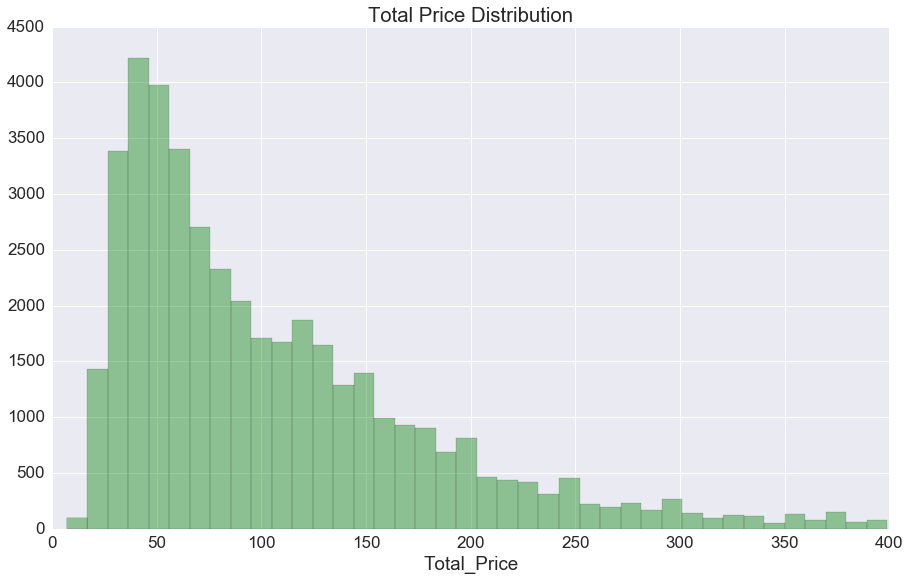

In [14]:
plt.figure(figsize = (15, 9))
sns.distplot(data.ix[data['Total_Price'] <400, 'Total_Price'],bins = 40, color = 'g',  kde= False)
plt.title('Total Price Distribution')

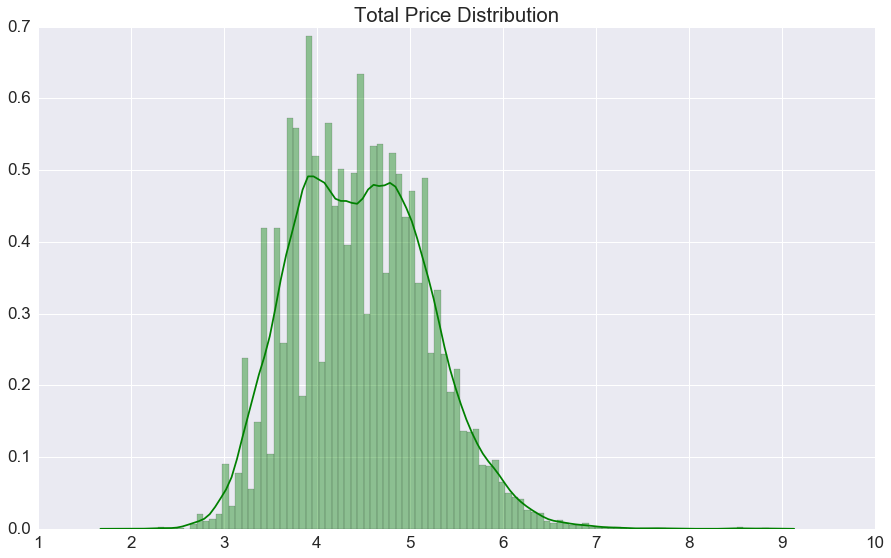

In [15]:
plt.figure(figsize = (15, 9))
sns.distplot(np.log(data['Total_Price'].values),bins = 100, color = 'g',  kde= True)
plt.title('Total Price Distribution')

In [16]:
price = data.ix[data['Total_Price'] <400, 'Total_Price'].values

In [119]:
np.log(price)

array([ 5.16478597,  4.27666612,  4.40671925, ...,  4.09434456,
        4.55387689,  3.8918203 ])

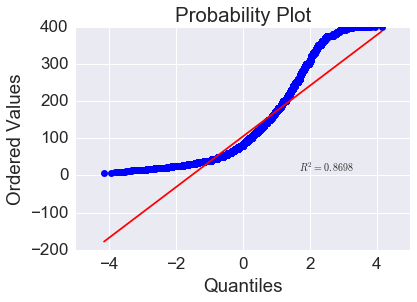

In [120]:
from scipy.stats import probplot
probplot(price, plot = plt);

In [121]:
price2 = data['Total_Price'].values

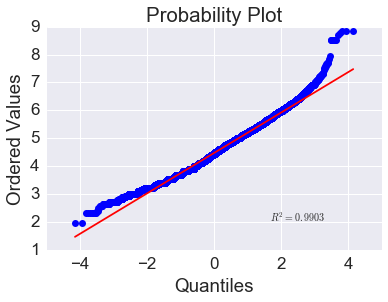

In [122]:
probplot(np.log(price2), plot = plt);

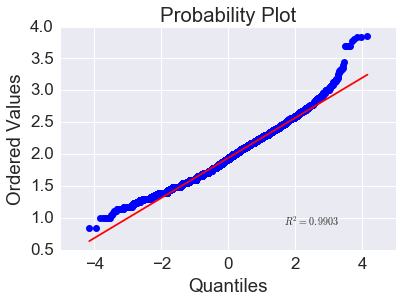

In [123]:
probplot(np.log10(price2), plot = plt);

In [17]:
col = data.columns.tolist()
col_new = col[-1:]+ col[:-1]
data = data[col_new]

In [18]:
## Convert time related data from string to standard datetime format 
host_since_dt = []
for t in raw['host_since']:
    try:
        host_since_dt.append(dt.strptime(t, '%Y-%m-%d'))
    except TypeError:
        host_since_dt.append(dt(2016,6,2))   

In [19]:
scraped_date = dt(2016, 6, 2)
data['host_days'] = [ (scraped_date - time).days for time in  host_since_dt]

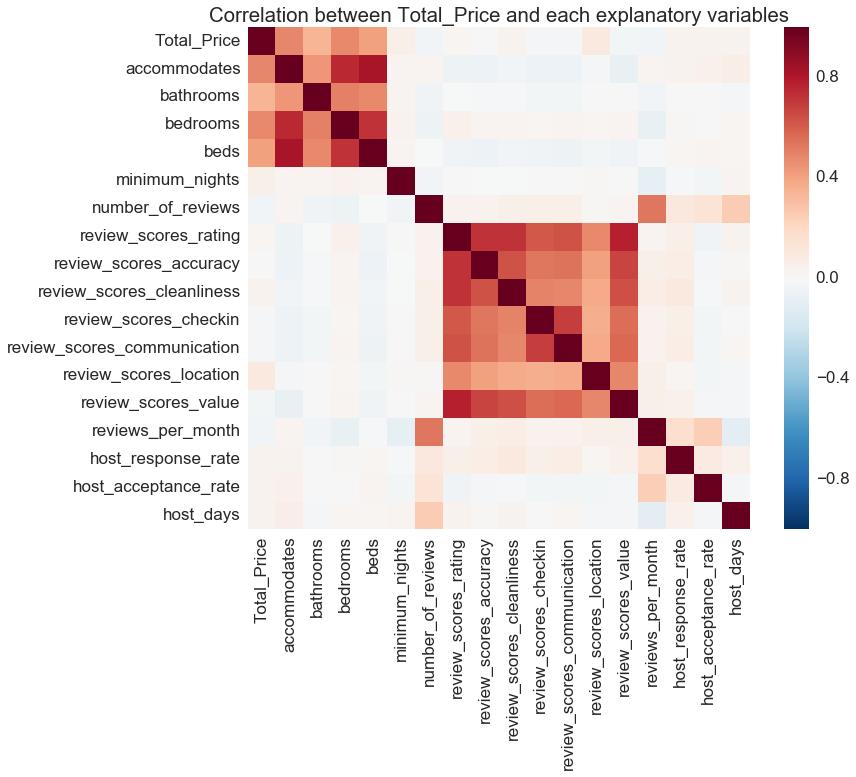

In [20]:
corr = data.drop(['price', 'cleaning_fee'], axis = 1).select_dtypes(include = ['float64', 'int64']).corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, vmax=1, square=True)
ax = plt.axes()
ax.set_title('Correlation between Total_Price and each explanatory variables')

In [21]:
## List all the nominal features
dummies =['experiences_offered', 'neighbourhood_cleansed', 'room_type', 'bed_type']

In [22]:
data = pd.concat((data, raw[dummies]), axis = 1)

In [23]:
data_new = data[data['Total_Price'] <=300]

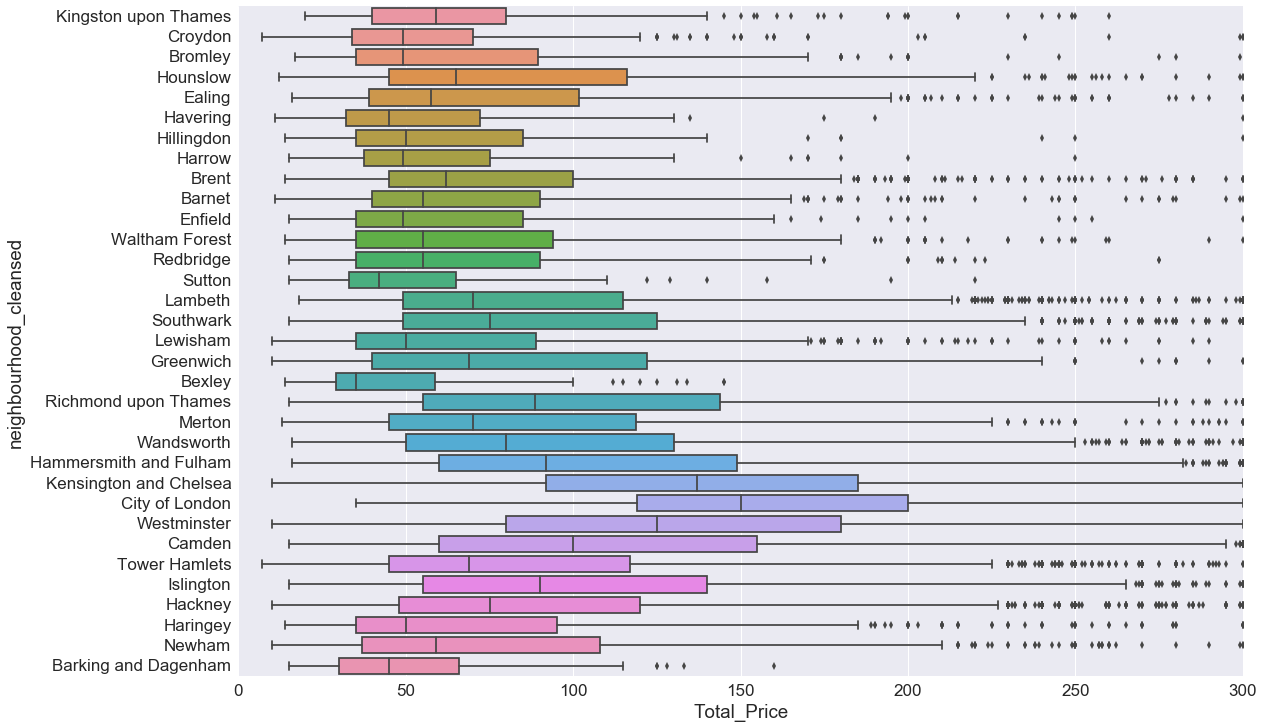

In [24]:
plt.figure(figsize = (18, 12))
sns.boxplot(y = dummies[1], x = 'Total_Price',  data = data_new, )

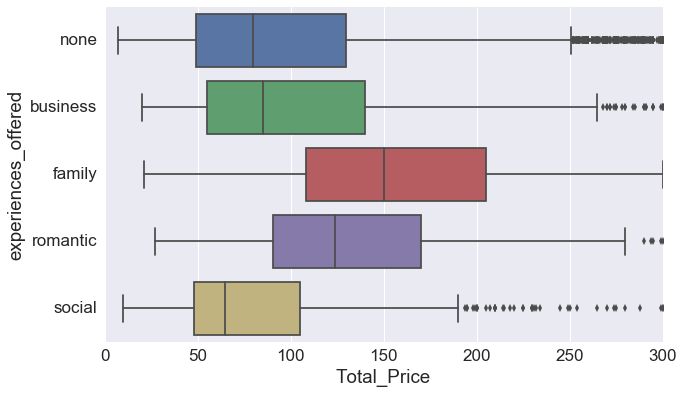

In [25]:
plt.figure(figsize = (10, 6))
sns.boxplot(y = dummies[0], x = 'Total_Price',  data = data_new, )

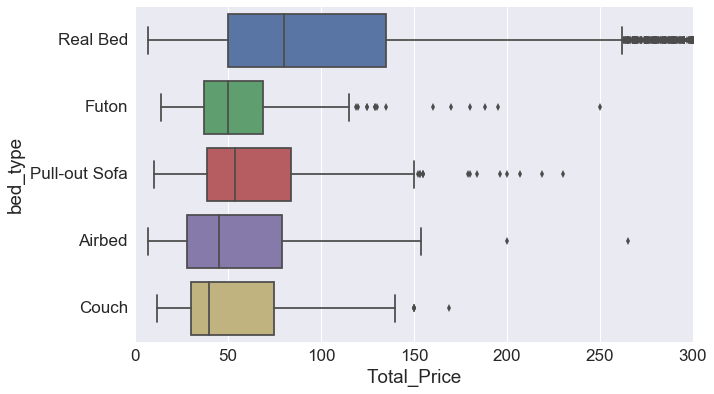

In [26]:
plt.figure(figsize = (10, 6))
sns.boxplot(y = dummies[3], x = 'Total_Price',  data = data_new, )

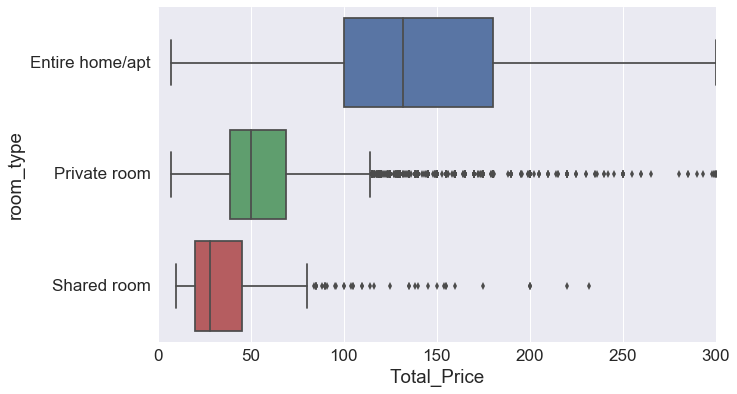

In [134]:
plt.figure(figsize = (10, 6))
sns.boxplot(y = dummies[2], x = 'Total_Price',  data = data_new, )

In [135]:
## List all the ordinal features
labels = ['host_response_time', 
          'host_is_superhost', 
          'host_has_profile_pic', 
          'host_identity_verified', 
          'instant_bookable', 
          'cancellation_policy', 
          'require_guest_profile_picture', 
          'require_guest_phone_verification']

In [136]:
data = pd.concat((data, raw[labels]), axis = 1)
data_new = data[data['Total_Price']<= 400]

In [137]:
data_new[labels] = data_new[labels].fillna('f')

In [138]:
X = data_new['Total_Price']
y = data_new[labels[1]]
colors = ['blue', 'red', 'green', 'yellow', 'm']
bins = np.linspace(0, 400, 10)
cat = y.unique()
n_cat = len(cat)

- Kernel Distribution in one plot http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html

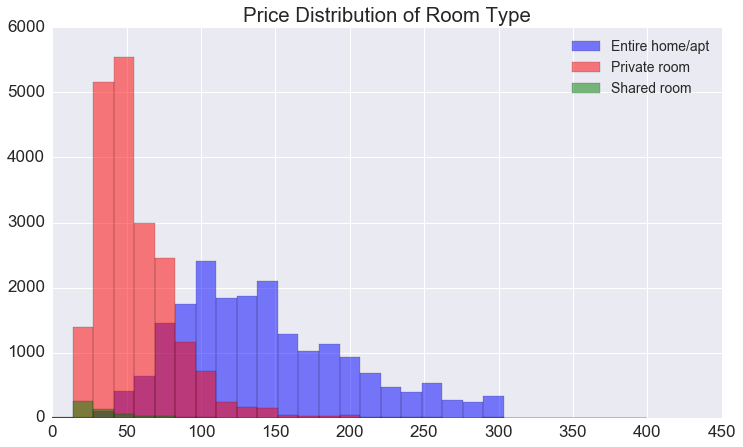

In [27]:
X = data_new['Total_Price']
y = data_new['room_type']
cat = y.unique()
n_cat = len(cat)
colors = ['blue', 'red', 'green', 'yellow', 'm']
bins = np.linspace(0, 400, 30)
fig, ax = plt.subplots(figsize = (12,7))
for lab, col in zip(cat, colors[:n_cat]):
    ax.hist(X[y == lab], color=col, label='%s' % lab, bins=bins, alpha=0.5,)
ylims = ax.get_ylim()
leg = ax.legend(loc='upper right', fancybox=True, fontsize=14)
leg.get_frame().set_alpha(0.5)
ax.set_ylim([0, max(ylims)+2])
ax.set_title('Price Distribution of Room Type')

(array([    3.,   254.,   922.,  1041.,   603.,   760.,   539.,   621.,
          392.,   327.,   374.,   213.,   174.,   220.,   146.,   119.,
           66.,    68.,   102.,    48.,    38.,    48.,    26.,    30.,
           18.,    31.,    21.,    12.,    27.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([    4.,   404.,  1425.,  1549.,   901.,  1092.,   684.,   785.,
          394.,   373.,   454.,   199.,   161.,   184.,   194.,   115.,
           71.,    70.,    94.,    30.,    33.,    68.,    18.,    20.,
            3.,    28.,    12.,    17.,    24.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([   10.,   462.,  1329.,  1453.,   945.,   896.,   809.,   779.,
          547.,   559.,   624.,   393.,   271.,   321.,   249.,   196.,
          124.,   106.,   138.,    75.,    66.,    82.,    38.,    48.,
           38.,    42.,    36.,    26.,    37.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([  1.00000000e+00,   5.08000000e+02,   1.63600000e+03,
          1.86400000e+03,   1.16300000e+03,   1.11600000e+03,
          8.37000000e+02,   8.90000000e+02,   7.20000000e+02,
          7.42000000e+02,   7.61000000e+02,   5.13000000e+02,
          4.43000000e+02,   4.33000000e+02,   3.80000000e+02,
          2.70000000e+02,   2.08000000e+02,   1.64000000e+02,
          2.10000000e+02,   1.19000000e+02,   1.02000000e+02,
          1.40000000e+02,   8.60000000e+01,   8.00000000e+01,
          6.70000000e+01,   6.20000000e+01,   5.30000000e+01,
          1.15000000e+02,   6.40000000e+01]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  31

(array([   0.,   43.,   93.,  110.,   68.,   67.,   53.,   47.,   24.,
          39.,   37.,   16.,    8.,    8.,   11.,   11.,    4.,    3.,
           7.,    3.,    2.,    8.,    0.,    6.,    1.,    3.,    3.,
           0.,    2.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(0, 2002.0)

(array([   18.,  1617.,  5135.,  5632.,  3412.,  3699.,  2740.,  2946.,
         1934.,  1907.,  2123.,  1245.,   989.,  1088.,   911.,   669.,
          437.,   390.,   522.,   258.,   226.,   327.,   158.,   171.,
          120.,   157.,   115.,   162.,   146.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([   0.,   54.,  270.,  385.,  268.,  232.,  182.,  176.,  143.,
         133.,  127.,   89.,   68.,   78.,   69.,   42.,   36.,   21.,
          29.,   17.,   15.,   19.,   10.,   13.,    7.,    9.,   10.,
           8.,    8.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(0, 6002.0)

(array([   17.,  1664.,  5387.,  5993.,  3669.,  3914.,  2904.,  3098.,
         2073.,  2034.,  2238.,  1332.,  1050.,  1165.,   975.,   711.,
          473.,   409.,   551.,   273.,   240.,   345.,   168.,   184.,
          127.,   166.,   125.,   170.,   154.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([  1.,   7.,  18.,  24.,  11.,  17.,  18.,  24.,   4.,   6.,  12.,
          2.,   7.,   1.,   5.,   0.,   0.,   2.,   0.,   2.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(0, 6002.0)

(array([    7.,   751.,  2761.,  3203.,  2103.,  2261.,  1801.,  1944.,
         1403.,  1349.,  1500.,   917.,   734.,   819.,   682.,   487.,
          343.,   289.,   389.,   208.,   183.,   240.,   138.,   129.,
          107.,   116.,   100.,   143.,   115.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([   11.,   920.,  2644.,  2814.,  1577.,  1670.,  1121.,  1178.,
          674.,   691.,   750.,   417.,   323.,   347.,   298.,   224.,
          130.,   122.,   162.,    67.,    58.,   106.,    30.,    55.,
           20.,    50.,    25.,    27.,    39.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(0, 3502.0)

(array([   15.,  1405.,  4563.,  5022.,  3087.,  3389.,  2513.,  2759.,
         1784.,  1692.,  1871.,  1099.,   827.,   944.,   793.,   560.,
          367.,   324.,   448.,   194.,   189.,   273.,   105.,   143.,
           91.,   133.,   100.,    78.,   123.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([   3.,  266.,  842.,  995.,  593.,  542.,  409.,  363.,  293.,
         348.,  379.,  235.,  230.,  222.,  187.,  151.,  106.,   87.,
         103.,   81.,   52.,   73.,   63.,   41.,   36.,   33.,   25.,
          92.,   31.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(0, 6002.0)

(array([    6.,   281.,  1090.,  1433.,   964.,   986.,   827.,   850.,
          533.,   556.,   563.,   321.,   237.,   270.,   166.,   150.,
           71.,    68.,    90.,    51.,    27.,    51.,    31.,    26.,
            9.,    24.,    14.,    86.,    13.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([   10.,   960.,  3002.,  2838.,  1546.,  1740.,  1022.,  1095.,
          575.,   462.,   584.,   269.,   216.,   217.,   254.,   123.,
           88.,    65.,   105.,    32.,    37.,    78.,    20.,    28.,
            8.,    37.,     9.,    20.,    33.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([    2.,   429.,  1311.,  1745.,  1170.,  1204.,  1073.,  1177.,
          969.,  1022.,  1103.,   744.,   604.,   679.,   560.,   438.,
          314.,   278.,   356.,   192.,   176.,   217.,   116.,   130.,
          109.,   103.,   102.,    64.,   108.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(0, 3502.0)

(array([   18.,  1636.,  5257.,  5870.,  3586.,  3841.,  2828.,  3043.,
         2020.,  1972.,  2182.,  1289.,  1018.,  1132.,   959.,   693.,
          462.,   405.,   532.,   272.,   234.,   332.,   166.,   180.,
          126.,   165.,   123.,   168.,   151.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([   0.,   35.,  148.,  147.,   94.,   90.,   94.,   79.,   57.,
          68.,   68.,   45.,   39.,   34.,   21.,   18.,   11.,    6.,
          19.,    3.,    7.,   14.,    2.,    4.,    1.,    1.,    2.,
           2.,    3.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(0, 6002.0)

(array([   18.,  1639.,  5246.,  5852.,  3574.,  3817.,  2803.,  2978.,
         1982.,  1939.,  2141.,  1264.,   986.,  1107.,   933.,   671.,
          456.,   397.,   525.,   257.,   224.,   327.,   158.,   177.,
          111.,   157.,   114.,   167.,   144.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(array([   0.,   32.,  159.,  165.,  106.,  114.,  119.,  144.,   95.,
         101.,  109.,   70.,   71.,   59.,   47.,   40.,   17.,   14.,
          26.,   18.,   17.,   19.,   10.,    7.,   16.,    9.,   11.,
           3.,   10.]),
 array([   0.        ,   13.79310345,   27.5862069 ,   41.37931034,
          55.17241379,   68.96551724,   82.75862069,   96.55172414,
         110.34482759,  124.13793103,  137.93103448,  151.72413793,
         165.51724138,  179.31034483,  193.10344828,  206.89655172,
         220.68965517,  234.48275862,  248.27586207,  262.06896552,
         275.86206897,  289.65517241,  303.44827586,  317.24137931,
         331.03448276,  344.82758621,  358.62068966,  372.4137931 ,
         386.20689655,  400.        ]),
 <a list of 29 Patch objects>)

(0, 6002.0)

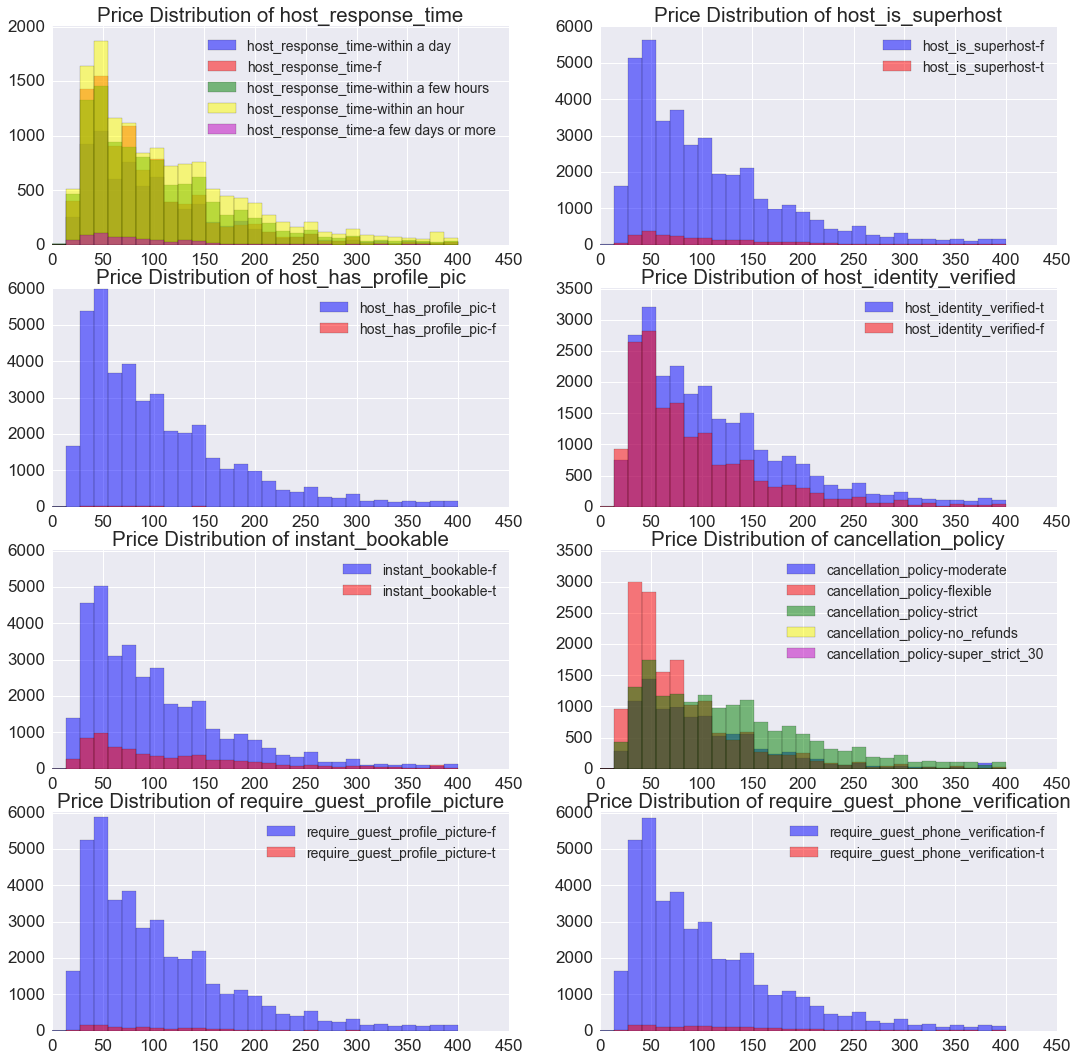

In [147]:
X = data_new['Total_Price']
colors = ['blue', 'red', 'green', 'yellow', 'm']
bins = np.linspace(0, 400, 30)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18,18))
for ax, cnt in zip(axes.ravel(), range(8)):  
    y = data_new[labels[cnt]]
    cat = y.unique()
    n_cat = len(cat)
    # plottling the histograms
    for lab, col in zip(cat, colors[:n_cat]):
        ax.hist(X[y == lab], color=col, label='%s-%s' % (labels[cnt], lab), bins=bins, alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=14)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_title('Price Distribution of %s' % labels[cnt])
 


In [148]:
data = data.drop(dummies, axis = 1)

In [149]:
## Define a function to convert nominal features into dummy variables
def add_dummies(col):
    return pd.get_dummies(raw[col], prefix = col)

In [150]:
## List all the nominal features
dummies =['experiences_offered', 'neighbourhood_cleansed', 'room_type', 'bed_type']

In [151]:
for col in dummies:
    col_dummies = add_dummies(col)
    data = pd.concat([data, col_dummies], axis =1 )

In [152]:
## Define a function to do the mapping for ordinal features
def encode_labels(col, mapping):
    return raw[col].map(mapping)

In [153]:
## Define mapping rules for ordinal features listed above, in order
mapping  = [{'within an hour': 0, 'within a few hours': 1, 'within a day': 2, 'a few days or more':3, np.nan: 4},
            {'f':0, 't':1},
            {'f':0, 't':1},
            {'f':0, 't':1},
            {'f':0, 't':1},
            {'strict': 1, 'super_strict_60':1, 'super_strict_30':1, 'no_refunds':1, 'moderate':2, 'flexible':3},
            {'f':0, 't':1},
            {'f':0, 't':1}]

In [154]:
for (col, mapping) in zip(labels, mapping):
    data[col] = encode_labels(col, mapping)

In [155]:
data = pd.concat((data, raw[['neighbourhood_cleansed', 'room_type']]), axis = 1)

In [156]:
data_new = data[data['Total_Price'] <= 400]
data_new = data_new.drop(['price', 'cleaning_fee'], axis =1)
data_new.head()

,Total_Price,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,...,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,neighbourhood_cleansed,room_type
0,175.0,6,1.0,3.0,4.0,4,6,87.0,8.0,9.0,...,1,0,0,0,0,0,0,1,Kingston upon Thames,Entire home/apt
1,72.0,3,1.0,1.0,2.0,1,5,96.0,10.0,10.0,...,0,1,0,0,0,0,0,1,Kingston upon Thames,Private room
2,82.0,2,1.0,0.0,1.0,5,4,95.0,10.0,10.0,...,1,0,0,0,0,0,0,1,Kingston upon Thames,Entire home/apt
3,145.0,3,1.0,1.0,2.0,1,14,88.0,10.0,8.0,...,1,0,0,0,0,0,0,1,Kingston upon Thames,Entire home/apt
4,45.0,2,1.0,1.0,1.0,1,3,93.0,10.0,10.0,...,0,1,0,0,0,1,0,0,Kingston upon Thames,Private room


In [157]:
%store data_new

Stored 'data_new' (DataFrame)


In [158]:
data_2 = raw[starting_columns].copy()

In [159]:
data_2['price'] = convert_prices('price')

data_2['cleaning_fee'] = convert_prices('cleaning_fee')

In [160]:
data_2['host_response_rate'] = convert_rate('host_response_rate')
data_2['host_acceptance_rate'] = convert_rate('host_acceptance_rate')

data_2['cleaning_fee'] = data['cleaning_fee'].fillna(0)
data_2['Total_Price'] = data['price'] + data['cleaning_fee']

In [161]:
data_2 = pd.concat((data_2, raw[dummies]), axis = 1)

In [162]:
data_2 = pd.concat((data_2, raw[labels]), axis = 1)

In [163]:
data_2_new = data_2[data_2['Total_Price']<= 400]

In [164]:
data_2_new[labels] = data_2_new[labels].fillna('f')

In [165]:
data_2_new = data_2_new.drop(['price', 'cleaning_fee'], axis =1)
data_2_new.head()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,room_type,bed_type,host_response_time,host_is_superhost,host_has_profile_pic,host_identity_verified,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,6,1.0,3.0,4.0,4,6,87.0,8.0,9.0,10.0,...,Entire home/apt,Real Bed,within a day,f,t,t,f,moderate,f,f
1,3,1.0,1.0,2.0,1,5,96.0,10.0,10.0,10.0,...,Private room,Real Bed,f,f,t,f,f,flexible,f,f
2,2,1.0,0.0,1.0,5,4,95.0,10.0,10.0,10.0,...,Entire home/apt,Real Bed,within a few hours,f,t,t,f,moderate,f,f
3,3,1.0,1.0,2.0,1,14,88.0,10.0,8.0,9.0,...,Entire home/apt,Real Bed,within a day,f,t,f,f,moderate,f,f
4,2,1.0,1.0,1.0,1,3,93.0,10.0,10.0,10.0,...,Private room,Futon,within a few hours,f,t,f,f,flexible,f,f


In [166]:
%store data_2_new

Stored 'data_2_new' (DataFrame)


In [167]:
len(raw['neighbourhood_cleansed'].unique())

33